# Praktikum 1 : RNN untuk Analisis Sentimen

## Setup
Impor matplotlib dan buat fungsi pembantu untuk memplot grafik

In [ ]:
# import library untuk pengolahan data numerik
import numpy as np

# import library untuk mengakses berbagai dataset yang digunakan dalam machine learning dan deep learning
import tensorflow_datasets as tfds

# Import modul untuk pengembangan model deep learning dengan TensorFlow
import tensorflow as tf

# Menonaktifkan tampilan progress bar ketika menggunakan tensorflow_datasets
tfds.disable_progress_bar()

In [ ]:
# Import modul matplotlib untuk membuat grafik (plot) dan visualisasi data 
import matplotlib.pyplot as plt

# Fungsi plot_graphs menerima dua parameter, yaitu history (riwayat pelatihan model) dan metric (metrik yang ingin diplot)
def plot_graphs(history, metric):
  
  # Menggambar grafik garis untuk metrik pada data pelatihan
  plt.plot(history.history[metric])
  
  # Menggambar grafik garis untuk metrik pada data validasi (validasi set)
  plt.plot(history.history['val_'+metric], '')
  
  # Memberi label sumbu x dengan "Epochs" 
  plt.xlabel("Epochs")
  
  # Memberi label sumbu y dengan nama metrik yang diberikan sebagai parameter
  plt.ylabel(metric)
  
  # Menambahkan legenda untuk grafik, mencantumkan metrik pelatihan dan metrik validasi
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline

In [ ]:
# Memuat dataset 'imdb_reviews' dari TensorFlow Datasets dan juga mendapatkan informasi dataset.
# 'with_info=True' digunakan untuk mendapatkan objek 'info' yang berisi metadata dataset.
# 'as_supervised=True' menghasilkan dataset yang sudah dalam bentuk pasangan (data, label).
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

# Memisahkan dataset menjadi dataset pelatihan (train_dataset) dan dataset pengujian (test_dataset)
train_dataset, test_dataset = dataset['train'], dataset['test']

# Melihat spesifikasi elemen dari train_dataset
train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Menentukan ukuran buffer untuk mengacak dataset
BUFFER_SIZE = 10000

# Menentukan ukuran batch (jumlah sampel yang akan digunakan dalam setiap iterasi pelatihan)
BATCH_SIZE = 64

# Mengacak (shuffle) dataset pelatihan dengan ukuran buffer sebelum membaginya menjadi batch
# serta menggunakan prefetching untuk mempercepat pelatihan.
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Membagi dataset pengujian menjadi batch dan menggunakan prefetching.
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# Mengambil satu batch dari dataset pelatihan sebagai contoh
for example, label in train_dataset.take(1):
  
  # Mencetak tiga contoh teks dari batch pertama dalam bentuk array NumPy
  print('texts: ', example.numpy()[:3])
  print()
  
  # Mencetak tiga label yang sesuai dengan contoh-contoh tersebut
  print('labels: ', label.numpy()[:3])


texts:  [b'This show had a lot of hype but I didn\'t know about it until the midseason (season 1). Someone even recommended the show to me. But I decided that if I was going to watch it, I was going to wait until the end of the season so I could watch it in bulk. Due to the show\'s format, I\'m happy I waited. I imagine it would have been fairly annoying have nearly every episode end in the middle of some cliff hanger then have to wait another week to find out what happens in the next second of the story.<br /><br />Somehow, this show has managed to throw in too much sex. Jason will have sex with pretty much anything that moves. Right after he finds out that one woman he had sex with was killed, he\'s in bed with another woman the next night! Then Tara and Sam get it on, despite each of them knowing that Sam is in love with Sookie. And for some reason, Sookie gets mad when she later finds out about it--even though she\'s sleeping with a vampire. One of the problems with the show, is th

## Membuat teks encoder

In [ ]:
# Menentukan ukuran vocab (daftar kata-kata yang akan diberikan representasi numerik)
VOCAB_SIZE = 1000

# Membuat layer TextVectorization dengan membatasi jumlah kata yang diambil sesuai dengan VOCAB_SIZE
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)

# Melakukan adaptasi (fitting) pada encoder menggunakan dataset pelatihan
# untuk memetakan kata-kata ke representasi numerik.
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
# Mendapatkan daftar vocab dari encoder (layer TextVectorization)
vocab = np.array(encoder.get_vocabulary())

# Mencetak 20 kata pertama dari vocab
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# Menggunakan encoder untuk mengonversi contoh teks menjadi representasi numerik
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11, 120,  67, ...,   0,   0,   0],
       [134,  82,  32, ...,   0,   0,   0],
       [ 31,   2,   1, ...,   0,   0,   0]])

In [ ]:
# Loop untuk menampilkan informasi tentang pemetaan dari teks ke representasi numerik
for n in range(3):
  print("Original: ", example[n].numpy()) # Mencetak teks asli
  print("Round-trip: ", " ".join(vocab[encoded_example[n]])) # Mencetak teks yang dihasilkan dari representasi numerik
  print()

Original:  b'This show had a lot of hype but I didn\'t know about it until the midseason (season 1). Someone even recommended the show to me. But I decided that if I was going to watch it, I was going to wait until the end of the season so I could watch it in bulk. Due to the show\'s format, I\'m happy I waited. I imagine it would have been fairly annoying have nearly every episode end in the middle of some cliff hanger then have to wait another week to find out what happens in the next second of the story.<br /><br />Somehow, this show has managed to throw in too much sex. Jason will have sex with pretty much anything that moves. Right after he finds out that one woman he had sex with was killed, he\'s in bed with another woman the next night! Then Tara and Sam get it on, despite each of them knowing that Sam is in love with Sookie. And for some reason, Sookie gets mad when she later finds out about it--even though she\'s sleeping with a vampire. One of the problems with the show, is 

## Membuat model

In [ ]:
# Membuat model sequential (berurutan) dengan beberapa lapisan (layers)
model = tf.keras.Sequential([
    # Menggunakan encoder (TextVectorization) untuk mengonversi teks ke representasi numerik
    encoder,
    
    # Lapisan embedding digunakan untuk menghasilkan vektor embedding dari representasi numerik kata-kata
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()), # Jumlah kata dalam vocab
        output_dim=64, # Dimensi vektor embedding
        mask_zero=True), # Menggunakan masking untuk menangani panjang teks yang bervariasi
    t
    # Lapisan Bidirectional LSTM digunakan untuk memproses teks dalam kedua arah (masuk dan keluar)
    f.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    
    # Lapisan Dense (fully connected) dengan fungsi aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),
    
     # Lapisan Dense terakhir dengan satu neuron dan fungsi aktivasi linear (regresi atau klasifikasi biner)
    tf.keras.layers.Dense(1)
])

In [ ]:
# Menggunakan list comprehension untuk mendapatkan informasi tentang dukungan masking untuk setiap lapisan dalam model
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# Menggunakan teks sampel tanpa padding
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

# Melakukan prediksi pada teks sampel tanpa padding dengan model
predictions = model.predict(np.array([sample_text]))
print(predictions[0]) # Mencetak hasil prediksi (output model)

1/1 [==============================] - 3s 3s/step
[0.00708413]


In [ ]:
# Mengompilasi model dengan konfigurasi loss, optimizer, dan metrik
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # Menggunakan BinaryCrossentropy untuk tugas klasifikasi biner
              optimizer=tf.keras.optimizers.Adam(1e-4), # Menggunakan optimizer Adam dengan learning rate 1e-4
              metrics=['accuracy']) # Metrik untuk memantau kinerja model

## Train Model

In [ ]:
# Melakukan pelatihan model dengan dataset pelatihan dan validasi
history = model.fit(train_dataset, # Dataset pelatihan
                    epochs=10, # Jumlah epoch pelatihan
                    validation_data=test_dataset, # Dataset validasi
                    validation_steps=30) # Jumlah langkah validasi

Epoch 1/10
391/391 [==============================] - 629s 2s/step - loss: 0.6716 - accuracy: 0.5194 - val_loss: 0.5733 - val_accuracy: 0.6599
Epoch 2/10
391/391 [==============================] - 613s 2s/step - loss: 0.4337 - accuracy: 0.7982 - val_loss: 0.3620 - val_accuracy: 0.8354
Epoch 3/10
391/391 [==============================] - 627s 2s/step - loss: 0.3458 - accuracy: 0.8489 - val_loss: 0.3440 - val_accuracy: 0.8448
Epoch 4/10
391/391 [==============================] - 606s 2s/step - loss: 0.3226 - accuracy: 0.8623 - val_loss: 0.3481 - val_accuracy: 0.8297
Epoch 5/10
391/391 [==============================] - 592s 2s/step - loss: 0.3140 - accuracy: 0.8646 - val_loss: 0.3249 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 609s 2s/step - loss: 0.3056 - accuracy: 0.8696 - val_loss: 0.3374 - val_accuracy: 0.8557
Epoch 7/10
391/391 [==============================] - 604s 2s/step - loss: 0.3016 - accuracy: 0.8712 - val_loss: 0.3260 - val_accuracy: 0.8583

In [ ]:
# Menghitung loss dan akurasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi model
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 154s 392ms/step - loss: 0.3207 - accuracy: 0.8613
Test Loss: 0.32066839933395386
Test Accuracy: 0.8613200187683105


(0.0, 0.6903487607836724)

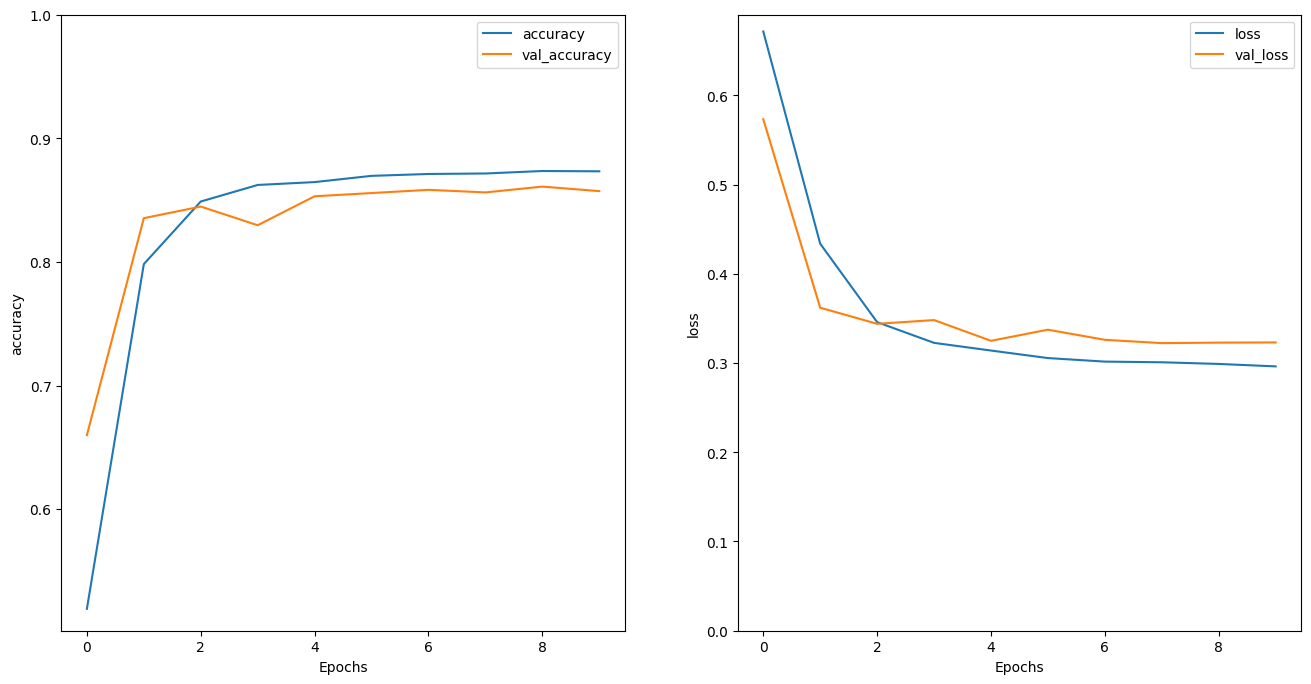

In [ ]:
# Membuat dua subplot dalam satu gambar untuk grafik
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)

# Memanggil fungsi plot_graphs untuk membuat grafik akurasi
plot_graphs(history, 'accuracy')
plt.ylim(None, 1) # Mengatur rentang sumbu y

plt.subplot(1, 2, 2)

# Memanggil fungsi plot_graphs untuk membuat grafik loss
plot_graphs(history, 'loss')
plt.ylim(0, None) # Mengatur rentang sumbu y

**Penjelasan :**<br>
Gambar diatas menunjukkan 2 grafik yang menggambarkan akurasi dan loss dari model RNN yang dilatih untuk analisis sentimen. Grafik akurasi menunjukkan bahwa akurasi model pada data pelatihan meningkat seiring waktu, mencapai maksimum 0,6903487607836724. Grafik loss menunjukkan bahwa loss model pada data pelatihan menurun seiring waktu, mencapai minimum 0,0.Grafik akurasi dan loss menunjukkan bahwa model RNN telah belajar untuk melakukan analisis sentimen dengan baik pada data pelatihan. <br><br>
**Grafik akurasi** menunjukkan persentase data pelatihan yang diklasifikasikan dengan benar oleh model. Semakin tinggi akurasi, semakin baik model tersebut dalam melakukan analisis sentimen.<br><br>
**Grafik loss** menunjukkan jumlah kesalahan yang dibuat oleh model pada data pelatihan. Semakin rendah loss, semakin baik model tersebut dalam melakukan analisis sentimen.

In [ ]:
# Menjalankan prediksi pada contoh teks menggunakan model yang sudah ada
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


## Stack two or more LSTM layers

In [ ]:
# Membuat model baru dengan arsitektur yang berbeda
model = tf.keras.Sequential([
    encoder, # Menggunakan encoder (TextVectorization)
    
    # Lapisan embedding dengan dimensi 64 dan masking
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    
    # Dua lapisan Bidirectional LSTM, yang menerima urutan sebagai keluaran
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    
    # Lapisan Dense dengan aktivasi ReLU
    tf.keras.layers.Dense(64, activation='relu'),
    
    # Lapisan Dropout untuk mengurangi overfitting
    tf.keras.layers.Dropout(0.5),
    
    # Lapisan Dense terakhir dengan satu neuron
    tf.keras.layers.Dense(1)
])

In [ ]:
# Mengompilasi model baru dengan konfigurasi yang sama seperti sebelumnya
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Melakukan pelatihan model baru dengan dataset pelatihan dan validasi selama 2 epoch
history = model.fit(train_dataset,  # Dataset pelatihan
                    epochs=2, # Jumlah epoch pelatihan
                    validation_data=test_dataset, # Dataset validasi
                    validation_steps=30) # Jumlah langkah validasi

Epoch 1/2
391/391 [==============================] - 1240s 3s/step - loss: 0.6375 - accuracy: 0.5781 - val_loss: 0.4449 - val_accuracy: 0.8021
Epoch 2/2
391/391 [==============================] - 1278s 3s/step - loss: 0.3912 - accuracy: 0.8289 - val_loss: 0.3555 - val_accuracy: 0.8344


In [ ]:
# Menghitung loss dan akurasi model pada dataset pengujian
test_loss, test_acc = model.evaluate(test_dataset)

# Mencetak hasil evaluasi model pada dataset pengujian
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 277s 708ms/step - loss: 0.3420 - accuracy: 0.8445
Test Loss: 0.3420248329639435
Test Accuracy: 0.8444799780845642


In [ ]:
# Melakukan prediksi pada contoh teks baru menggunakan model yang baru dilatih
sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))

# Mencetak hasil prediksi
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-0.48791713]]


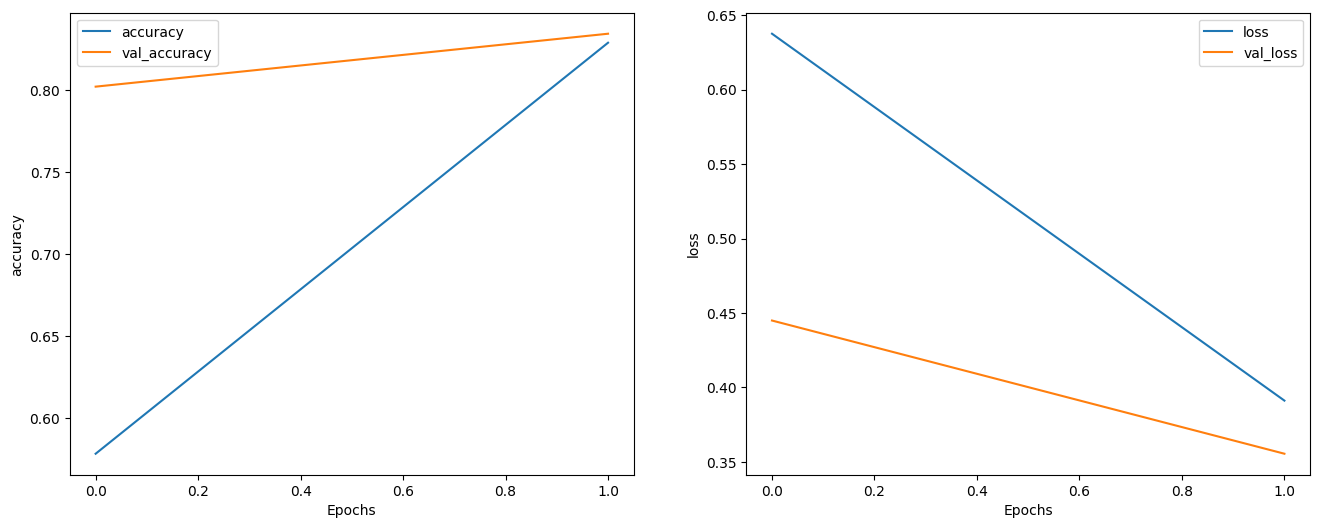

In [ ]:
# Membuat gambar dengan dua subplot untuk grafik kinerja model
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)

# Memanggil fungsi plot_graphs untuk membuat grafik akurasi
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)

# Memanggil fungsi plot_graphs untuk membuat grafik loss
plot_graphs(history, 'loss')

**Gambar pertama** menunjukkan grafik akurasi dan loss dari model pada data pelatihan dan data uji. Grafik akurasi menunjukkan bahwa akurasi model pada data pelatihan dan data uji meningkat seiring waktu. Grafik loss menunjukkan bahwa loss model pada data pelatihan dan data uji menurun seiring waktu. Berdasarkan grafik tersebut, model RNN tampaknya dapat melakukan analisis sentimen dengan cukup baik. Akurasi model pada data pelatihan dan data uji mencapai 0,84. Loss model pada data pelatihan dan data uji mencapai 0,34. <br><br>
**Gambar kedua** menunjukkan hasil prediksi model pada contoh teks baru. Contoh teks tersebut adalah "The movie was not good. The animation and the graphics were terrible. I would not recommend this movie." Hasil prediksi menunjukkan bahwa model memprediksi bahwa teks tersebut memiliki sentimen negatif. Berdasarkan hasil prediksi tersebut, dapat disimpulkan bahwa model RNN dapat digunakan untuk menganalisis sentimen teks dengan cukup baik. Model tersebut dapat digunakan untuk mengidentifikasi teks yang memiliki sentimen positif atau negatif.